<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Model Training with the TAO Toolkit #
By way of review, this diagram illustrates is what a typical model development workflow looks like. We started by preparing the data and a pre-trained model. Next, we will train the model with new data and evaluate its performance. We will then export the model once its satisfactory. _Note that this does not include the optimization for inference, which we will explore in the next notebook._

<p><img src='images/pre-trained_model_workflow.png' width=1080></p>

## Learning Objectives ##
In this notebook, you will learn how to use the TAO Toolkit to train a video AI model, including: 
* Taking the Purpose-Built TrafficCamNet Model and Training a Custom ResNet18 DetectNet_v2 Model for Object Detection
* Creating Model Training, Evaluation, and Inference Configuration Files
* Evaluating Model
* Deploying Model to DeepStream

**Table of Contents** <br>
This notebook covers the below sections: 
1. [Model Training](#s1)
    * [Exercise #1 - Modify Data Set Config](#e1)
    * [Exercise #2 - Modify Augmentation Config](#e2)
    * [Exercise #3 - Modify Model Config](#e3)
    * [Exercise #4 - Modify BBox Rasterizer Config](#e4)
    * [Exercise #5 - Modify Post-Processing Config](#e5)
    * [Exercise #6 - Modify Training Config](#e6)
    * [Cost Function Config](#s1.1)
    * [Exercise #7 - Modify Evaluation Config](#e7)
    * [Initiate Model Training](#s1.2)
2. [Evaluating the Model](#s2)
3. [Model Inference](#s3)
    * [Exercise #8 - Modify Inferencer Config](#e8)
    * [Exercise #9 - Modify BBox Handler Config](#e9)
    * [Visualize Inference](#s3.1)
4. [Model Export](#s4)
    * [Model Export as TensorRT Engine](#s4.1)
5. [Deploying to DeepStream](#s5)

<a name='s1'></a>
## Model Training ##
Training configuration is done through a training spec file, which includes options such as which data set to use for training, which data set to use for validation, which pre-trained model architecture to use, which hyperparamters to tune, and other training options. The `train` and `evaluate` subtasks for a DetectNet_v2 experiment share the same configuration file. Configuration files can be created from scratch or modified using the templates provided in TAO Toolkit's [sample applications](https://docs.nvidia.com/tao/tao-toolkit/#cv-applications). 

<p><img src='images/rewind.png' width=720></p>

_Recall that when working with purpose-built models from NGC, the correct **encryption key** is required to load the model. Users will be able to define their own export encryption key when traing from a general purpose model. This is to protect proprietary IP and used to decrypt the `.etlt` model in DeepStream applications._

<p><img src='images/encryption_key.png' width=540></p>

The training configuration file has eight sections: 
* `dataset_config`
* `augmentation_config`
* `model_config`
* `bbox_rasterizer_config`
* `postprocessing_config`
* `training_config`
* `cost_function_config`
* `evaluation_config`

<p><img src='images/important.png' width=720></p>
We will create the configuration files using templates. Specifically, we have broken the configuration files into separate parts for ease of discussion, which we will combine at the end for the TAO Toolkit to consume. 

Execute the below cells to preview the combined training/evaluation configuration file that will be used. It is currently not usable as we have made some intentional modifications that will require correction. 

In [1]:
# DO NOT CHANGE THIS CELL
# Set and create directories for the TAO Toolkit experiment
import os

os.environ['PROJECT_DIR']='/dli/task/tao_project'
os.environ['SOURCE_DATA_DIR']='/dli/task/data'
os.environ['DATA_DIR']='/dli/task/tao_project/data'
os.environ['MODELS_DIR']='/dli/task/tao_project/models'
os.environ['SPEC_FILES_DIR']='/dli/task/spec_files'

In [2]:
# DO NOT CHANGE THIS CELL
# Combining configuration components in separate files and writing into one
!cat $SPEC_FILES_DIR/dataset_config.txt \
     $SPEC_FILES_DIR/augmentation_config.txt \
     $SPEC_FILES_DIR/model_config.txt \
     $SPEC_FILES_DIR/bbox_rasterizer_config.txt \
     $SPEC_FILES_DIR/postprocessing_config.txt \
     $SPEC_FILES_DIR/training_config.txt \
     $SPEC_FILES_DIR/cost_function_config.txt \
     $SPEC_FILES_DIR/evaluation_config.txt \
     > $SPEC_FILES_DIR/combined_training_config.txt
!cat $SPEC_FILES_DIR/combined_training_config.txt

dataset_config: {
  data_sources: {
    tfrecords_path: "/dli/task/<<<<FIXME>>>>"
    image_directory_path: "/dli/task/<<<<FIXME>>>>"
  }
  image_extension: "<<<<FIXME>>>>"
  target_class_mapping: {
      key: "<<<<FIXME>>>>"
      value: "<<<<FIXME>>>>"
  }
  validation_fold: 0
}
########## LEAVE NEW LINE BELOW
augmentation_config: {
  preprocessing: {
    output_image_width: <<<<FIXME>>>>
    output_image_height: <<<<FIXME>>>>
    output_image_channel: <<<<FIXME>>>>
    min_bbox_width: 1.0
    min_bbox_height: 1.0
  }
  spatial_augmentation: {
    hflip_probability: 0.5
    vflip_probability: 0.5
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation: {
    color_shift_stddev: 0.0
    hue_rotation_max: 25.0
    saturation_shift_max: 0.2
    contrast_scale_max: 0.1
    contrast_center: 0.5
  }
}
########## LEAVE NEW LINE BELOW
model_config: {
  arch: "resnet"
  pretrained_model_file: "/dli/task/<<<<FIXME>>>>"
  freeze_blocks: 0
 

<a name='e1'></a>
#### Exercise #1 - Modify Data Set Config ####
The dataloader defines the path to the data to be trained on and the class mapping for the classes in the data set. We have previously generate TFRecords for the training data sets. To use the newly generated TFRecords, update the `dataset_config` parameter in the spec file to reference the correct directory. Another parameter to consider is `validation_fold`, which we can use `0` to indicate _random data split_. For sequence-wise split, we can use any fold generated from the dataset convert tool. 
* `data_sources (dict)`: Captures the path to TFRecords to train on. 
    * `tfrecords_path (str)`: Path to the training TFRecords root/TFRecords_name*, i.e. **/data/tfrecords/kitti_trainval/***.
    * `image_directory_path (str)`: Path to the training data source from which the TFRecords was generated. 
* `image_extension (str)`: Extension of the images to be used without the `.`. 
* `target_class_mapping (dict)`: This parameter maps the class names in the TFRecords to the target class to be trained. This field enables grouping similar class objects under one umbrella. 
    * `key (str)`: Value of the class name in the TFRecords file. This must be identical to the one shown in the data set converter log. 
    * `value (str)`: Corresponds to the value that the network is expected to learn. 
* `validation_fold (int)`: In case of an n-fold TFRecords, you define the index of the fold to use for validation. For _random split_ partitioning, force the validation fold index to 0 as the TFRecord is just 2-fold. 

**Instructions**:<br>
* Modify the `dataset_config`[(here)](spec_files/dataset_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [3]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/dataset_config.txt

dataset_config: {
  data_sources: {
    tfrecords_path: "/dli/task/<<<<FIXME>>>>"
    image_directory_path: "/dli/task/<<<<FIXME>>>>"
  }
  image_extension: "<<<<FIXME>>>>"
  target_class_mapping: {
      key: "<<<<FIXME>>>>"
      value: "<<<<FIXME>>>>"
  }
  validation_fold: 0
}
########## LEAVE NEW LINE BELOW


In [ ]:
dataset_config: {
  data_sources: {
    tfrecords_path: "/dli/task/tao_project/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/dli/task/tao_project/data/training"
  }
  image_extension: "png"
  target_class_mapping: {
       key: "car"
       value: "car"
   }
   validation_fold: 0
 }

Click ... to show **solution**. 

<a name='e2'></a>
#### Exercise #2 - Modify Augmentation Config ####
When using one’s own data set to train and fine-tune a model, the data set can be augmented while training to introduce variations in the data set. This is known as **online augmentation**. This is very useful in training as data variation improves the overall quality of the model and prevents [overfitting](https://en.wikipedia.org/wiki/Overfitting). Training a deep neural network requires large amounts of annotated data, which can be a manual and expensive process. Furthermore, it can be difficult to estimate all the corner cases that the network may go through. The TAO Toolkit provides _spatial augmentation_ (rotate, resize, translate, shear, and flip), _color space augmentation_ (hue rotation, brightness offset, and contrast shift), and _image blur_ to create synthetic data variations. 

For some of the values, we will need to review the [model card](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tlt_trafficcamnet). 

<p><img src='images/model_card_tao.png' width=720></p>

* `preprocessing (dict)`: Configures the input image and ground truth label pre-processing module. 
    * `output_image_width (int)`: This is the same as the width of the network input. 
    * `output_image_height (int)`: This is the same as the height of the network input. 
    * `output_image_channel (int)`: This is the same as the channel depth of the network input _(1, 3)_. 
    * `min_bbox_width (float)`: Minimum width of the object labels to be considered for training. 
    * `min_bbox_height (float)`: Minimum height of the object labels to be considered for training. 
* `spatial_augmentation (dict)`: Supports spatial augmentation such as flip, zoom, and translate. 
    * `hflip_probability (float)`: Probability to flip an input image horizontally _(0.0 - 1.0)_. 
    * `vflip_probability (float)`: Probability to flip an input image vertically _(0.0 - 1.0)_. 
    * `zoom_min (float)`: Minimum zoom scale of the input image _(> 0.0)_. 
    * `zoom_max (float)`: Maximum zoom scale of the input image _(> 0.0)_. 
    * `translate_max_x (int)`: Maximum translation to be added across the x-axis _(0.0 - output_image_width)_. 
    * `translate_max_y (int)`: Maximum translation to be added across the y-axis _(0.0 - output_image_height)_. 
    * `rotate_rad_max (float)`: Angle of rotation to be applied to the images and the training labels _(> 0.0)_. 
* `color_augmentation (dict)`: Configures the color space transformation. 
    * `color_shift_stddev (float)`: Standard deviation value for the color shift _(0.0 - 1.0)_. 
    * `hue_rotation_max (float)`: Maximum rotation angle for the hue rotation matrix _(0.0 - 360.0)_. 
    * `saturation_shift_max (float)`: Maximum shift that changes the saturation _(0.0 - 1.0)_. 
    * `contrast_scale_max (float)`: Slope of the contrat as rotated around the provided center _(0.0 - 1.0)_. 
    * `contrast_center (float)`: Center around which the contrast is rotated _(set to 0.5)_. 

**NOTE**: If the output image height and output image width of the preprocessing block don’t match with that of the input images mentioned while generating the TFRecords, the images will be either randomly padded or cropped to fit the input resolution.

**Instructions**:<br>
* Modify the `augmentation_config`[(here)](spec_files/augmentation_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [4]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/augmentation_config.txt

augmentation_config: {
  preprocessing: {
    output_image_width: <<<<FIXME>>>>
    output_image_height: <<<<FIXME>>>>
    output_image_channel: <<<<FIXME>>>>
    min_bbox_width: 1.0
    min_bbox_height: 1.0
  }
  spatial_augmentation: {
    hflip_probability: 0.5
    vflip_probability: 0.5
    zoom_min: 1.0
    zoom_max: 1.0
    translate_max_x: 8.0
    translate_max_y: 8.0
  }
  color_augmentation: {
    color_shift_stddev: 0.0
    hue_rotation_max: 25.0
    saturation_shift_max: 0.2
    contrast_scale_max: 0.1
    contrast_center: 0.5
  }
}
########## LEAVE NEW LINE BELOW


In [ ]:
augmentation_config: {
   preprocessing: {
     output_image_width: 960
     output_image_height: 544
     output_image_channel: 3
     min_bbox_width: 1.0
     min_bbox_height: 1.0
   }
   spatial_augmentation: {
     hflip_probability: 0.5
     vflip_probability: 0.5
     zoom_min: 1.0
     zoom_max: 1.0
     translate_max_x: 8.0
     translate_max_y: 8.0
   }
   color_augmentation: {
     color_shift_stddev: 0.0
     hue_rotation_max: 25.0
    saturation_shift_max: 0.2
    contrast_scale_max: 0.1
     contrast_center: 0.5
   }
 }

Click ... to show **solution**. 

<a name='e3'></a>
#### Exercise #3 - Modify Model Config ####
The core Object Detection model can be configured using the `model_config` option in the spec file. 
* `arch (str)`: Architecture of the backbone feature extractor _(default="resnet")_. 
* `pretrained_model_file (str)`: Path to the pre-trained TAO model file. 
* `num_layers (int)`: Depth of the feature extractor for scalable templates. 
* `use_pooling (bool)`: Choose bteween using strided convolutions or MaxPooling while downsampling. We recommend setting this to `false` and using strided convolution. 
* `objective_set (dict)`: Objective for training the network. For Object Detection networks, set it to learn `cov` and `bbox`. These should not be altered. 
    * `bbox`
        * `scale`: `35.0`
        * `offset`: `0.5`
    * `cov`
* `dropout_rate (float)`: Probability for drop out _(0.0 - 1.0)_. 
* `load_graph (bool)`: Flag to determine whether or not to load the graph from the pretrained model, or just the weight. For a pruned model, set this parameter to `true` since both the model graph and the weights need to be imported. 
* `freeze_blocks (float)`: Defines which blocks may be frozen from the instantiated feature extractor template. Freezing a layer in the context of neural networks is about controlling if the weights are updated. When a layer is frozen, such as those in the feature extractor, it means that the weights cannot be modified further. This technique is used to cut down on the computational time for training. More information about Freeze Layers can be found in [TensorFlow's Transfer Learning and Fine-tuning Guide](https://www.tensorflow.org/guide/keras/transfer_learning#freezing_layers_understanding_the_trainable_attribute). 
* `use_batch_norm (bool)`: Flag to determine whether to use Batch Normalization layers or not _(default=false)_. Batch Normalization is a technique for training very deep neural networks like the ones we're using that standardizes the inputs to a layer for each mini-batch. This is to combat **internal covariate shift**, which occurs when the distribution of the inputs to layers deep in the network change after each mini-batch when the weights are updated. Batch Normalization can stabilize the learning process and dramatically reduce the number of training epochs required to train deep networks. You can find more information about Batch Normalization in [TensorFlow's API documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization). 
* `freeze_bn (bool)`: Determines whether to freeze the Batch Normalization layers in the module during training. 

**Instructions**:<br>
* Modify the `model_config`[(here)](spec_files/model_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [ ]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/model_config.txt

In [ ]:
model_config: {
   arch: "resnet"
   pretrained_model_file: "/dli/task/tao_project/models/trafficcamnet_vunpruned_v1.0/resnet18_trafficcamnet.tlt"
   freeze_blocks: 0
   freeze_blocks: 1
   num_layers: 18
   use_pooling: false
   use_batch_norm: true
   dropout_rate: 0.0
   objective_set: {
     cov: {}
     bbox: {
       scale: 35.0
       offset: 0.5
     }
   }
 }

Click ... to show **solution**. 

<a name='e4'></a>
#### Exercise #4 - Modify Bbox Rasterizer Config ####
The DetectNet_v2 generates 2 tensors: `cov` and `bbox`. The image is divided into 16x16 grid cells. The `cov` (_coverage_) tensor defines the number of grid cells that are covered by an object. The `bbox` tensor defines the normalized image coordinates of the object top left and bottom right with respect to the grid cell. 
* `deadzone radius (float)`: Area to be considered dormant around the ellipse of an object. This is useful in cases of overlapping objects so that foreground objects and background objects are not confused _(0.0 - 1.0)_. 
* `target_class_config (dict)`: Defines the coverage region for an object of a given class and is repeated for each class. 
    * `cov_center_x (float)`: x-coordinate of the center of the object _(0.0 - 1.0)_. 
    * `cov_center_y (float)`: y-coordinate of the center of the object _(0.0 - 1.0)_. 
    * `cov_radius_x (float)`: x-radius of the coverage ellipse _(0.0 - 1.0)_. 
    * `cov_radius_y (float)`: y-radius of the coverage ellipse _(0.0 - 1.0)_. 
    * `bbox_min_radius (float)`: Minimum radius of the coverage region to be drawn for boxes _(0.0 - 1.0)_. 

**Instructions**:<br>
* Modify the `bbox_rasterizer_config`[(here)](spec_files/bbox_rasterizer_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [5]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/bbox_rasterizer_config.txt

bbox_rasterizer_config: {
  target_class_config: {
    key: "<<<<FIXME>>>>"
    value: {
      cov_center_x: 0.5
      cov_center_y: 0.5
      cov_radius_x: 0.4
      cov_radius_y: 0.4
      bbox_min_radius: 1.0
    }
  }
  deadzone_radius: 0.4
}
########## LEAVE NEW LINE BELOW


In [ ]:
bbox_rasterizer_config: {
   target_class_config: {
     key: "car"
    value: {
      cov_center_x: 0.5
       cov_center_y: 0.5
       cov_radius_x: 0.4
       cov_radius_y: 0.4
       bbox_min_radius: 1.0
     }
   }
   deadzone_radius: 0.4
 }

Click ... to show **solution**. 

<a name='e5'></a>
#### Exercise #5 - Modify Post-Processing Config ####
The post-processor module generates renderable bounding boxes from the raw detection output. The process includes: 
1. Filtering out valid detections by thresholding objects using the confidence value in the coverage tensor. 
2. Clustering the raw filtered predictions using DBSCAN to produce the final rendered bounding boxes. 
3. Filtering out weaker clusters based on the final confidence threshold derived from the candidate boxes that get grouped into a cluster.
* `target_class_config (dict)`: For each class that is being trained for, the `postprocessing_config` has a `target_class_config` element that defines the clustering parameters for the class. 
    * `key (str)`: Name of the class. 
    * `value (dict)`: Clustering-config proto parameter that configures the post-processor module. 
        * `cluster_config (dict)`: 
            * `coverage_threshold (float)`: Minimum threshold of the coverage tensor output to be considered a valid candidate box for clustering _(0.0 - 1.0)_. 
            * `dbscan_eps (float)`: Maximum distance between two samples for one to be considered in the neighborhood of the other. The greater the dbscan_eps, the more boxes are grouped together _(0.0 - 1.0)_. 
            * `dbscan_min_samples (float)`: The total weight in a neighborhood for a point to be considered as a core point _(0.0 - 1.0)_. 
            * `minimum_bounding_box_height (int)`: Minimum height in pixels to consider as a valid detection post clustering _(0 - input image height)_. 
            * `clustering_algorithm (enum)`: Defines the post-processing algorithm (DBSCAN i.e. Density Based Spatial Clustering of Application, NMS i.e. Non-Maximal Suppression, or HYBRID) to cluster raw detections to the final bbox render (default=DBSCAN). When using HYBRID mode, ensure both DBSCAN and NMS configuration parameters are defined. 
            * `DBSCAN` - `dbscan_confidence_threshold (float)`: Confidence threshold used to filter out clustered bounding box output from DBSCAN _(> 0.0, default=0.1)_. 
            * `NMS` - `nms_iou_threshold (float)`: Intersection Over Union threshold to filter out redundant boxes from raw detection to form final clustered outputs _((0.0 - 1.0), default=0.2)_. 
            * `NMS` - `nms_confidence_threshold (float)`: Confidence threshold to filter out clustered bounding boxes from NMS _(0.0 - 1.0, default=0)_. 

**Instructions**:<br>
* Modify the `postprocessing_config`[(here)](spec_files/postprocessing_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [6]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/postprocessing_config.txt

postprocessing_config: {
  target_class_config: {
    key: "<<<<FIXME>>>>"
    value: {
      clustering_config: {
        coverage_threshold: 0.005
        dbscan_eps: 0.15
        dbscan_min_samples: 0.05
        minimum_bounding_box_height: 20
      }
    }
  }
}
########## LEAVE NEW LINE BELOW


In [ ]:
postprocessing_config: {
   target_class_config: {
     key: "car"
     value: {
       clustering_config: {
         coverage_threshold: 0.005
         dbscan_eps: 0.15
         dbscan_min_samples: 0.05
         minimum_bounding_box_height: 20
       }
     }
   }
 }

Click ... to show **solution**. 

<a name='e6'></a>
#### Exercise #6 - Modify Training Config ####
The `training_config` describes the training and learning process. 
* `batch_size_per_gpu (int)`: Number of images per batch per GPU _(> 1)_. 
* `num_epochs (int)`: Total number of epochs to run the experiment. 
* `learning_rate (dict)`: Define the learning rate schedule. Currently DetectNet_v2 only supports: 
    * `soft_start_annealing_schedule (dict)`, which is configured using: 
        * `soft_start (float)`: Time to ramp up the learning rate from minimum learning rate to maximum learning rate _(0.0 - 1.0)_. 
        * `annealing (float`: Time to cool down the learning rate from maximum learning rate to minimum learning rate _(0.0 - 1.0)_. 
        * `minimum learning rate (float)`: Minimum learning rate in the learning rate schedule _(0.0 - 1.0)_. 
        * `maximum learning rate (float)`: Maximum learning rate in the learning rate schedule _(0.0 - 1.0)_. 
* `regularizer (dict)`: Type and weight of the regularizer to be used during training. **It’s a good practice to start with a low regularization weight and gradually fine-tune it to narrow the gap between the training and the validation accuracy. Also, based on our experiments, L1 seems to give us better pruning ratio.**
    * `type (enum)`: Supported types are _(NO_REG, L1, L2)_. 
    * `weight (float)`: Weight of the regularizer. 
* `optimizer (dict)`: Optimizer to use for training. 
    * `adam (dict)`
        * `epsilon (float)`: Small number to prevent any division by zero in the implementation. 
        * `beta1 (float)`
        * `beta2 (float)`
* `cost_scaling (dict)`: Enables cost scaling during training. **Leave this parameter untouched currently for the DetectNet_v2 training pipe**. 
    * `enabled`: false. 
    * `initial_exponent`: 20.0. 
    * `increment`: 0.005. 
    * `derement`: 1.0. 
* `checkpoint_interval (int)`: Interval (in epochs) at which `train` saves intermediate models _(0 - num_epochs)_.
* `enable_qat (bool)`: Enables model training using Quantization-Aware Training (QAT). 

**Instructions**:<br>
* Modify the `training_config`[(here)](spec_files/training_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. Pick a low (recommend 10) `num_epochs` to start as the higher the number of epochs the longer the model trains. 

In [7]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/training_config.txt

training_config: {
  batch_size_per_gpu: 16
  num_epochs: <<<<FIXME>>>>
  learning_rate: {
    soft_start_annealing_schedule: {
      min_learning_rate: 5e-6
      max_learning_rate: 5e-4
      soft_start: 0.1
      annealing: 0.7
    }
  }
  regularizer: {
    type: L1
    weight: 3e-9
  }
  optimizer: {
    adam: {
      epsilon: 1e-08
      beta1: 0.9
      beta2: 0.999
    }
  }
  cost_scaling: {
    enabled: false
    initial_exponent: 20.0
    increment: 0.005
    decrement: 1.0
  }
  checkpoint_interval: <<<<FIXME>>>>
}
########## LEAVE NEW LINE BELOW


In [ ]:
training_config: {
   batch_size_per_gpu: 16
   num_epochs: 10
   learning_rate: {
     soft_start_annealing_schedule: {
       min_learning_rate: 5e-6
       max_learning_rate: 5e-4
       soft_start: 0.1
       annealing: 0.7
     }
   }
   regularizer: {
     type: L1
     weight: 3e-9
   }
   optimizer: {
     adam: {
       epsilon: 1e-08
       beta1: 0.9
       beta2: 0.999
     }
   }
  cost_scaling: {
     enabled: false
     initial_exponent: 20.0
     increment: 0.005
     decrement: 1.0
   }
   checkpoint_interval: 5
 }

Click ... to show **solution**. 

<a name='s1.1'></a>
### Cost Function Config ###
The cost function describes how each class is being trained. For best performance, we don't need to change the the parameters within the spec file besides making sure there is an entry for each of the target classes. The other parameters here should remain unchanged. Below is a sample configuration file: 

In [8]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/cost_function_config.txt

cost_function_config: {
  target_classes: {
    name: "car"
    class_weight: 1.0
    coverage_foreground_weight: 0.05
    objectives: {
      name: "cov"
      initial_weight: 1.0
      weight_target: 1.0
    }
    objectives {
      name: "bbox"
      initial_weight: 10.0
      weight_target: 10.0
    }
  }
  enable_autoweighting: true
  max_objective_weight: 0.9999
  min_objective_weight: 0.0001
}
########## LEAVE NEW LINE BELOW


<a name='e7'></a>
#### Exercise #7 - Modify Evaluation Config ####
The evaluator can be configured using the `evaluation_config` parameters. 
* `average_precision_mode (enum)`: Model _(SAMPLE or INTEGRATE)_ in which the average precision is calculated. 
* `validation_period_during_training (int)`: Interval at which evaluation is run during training _(1 - total number of epochs)_. 
* `first_validation_epoch (int)`: First epoch to start running validation _(1 - total number of epochs)_. 
* `minimum_detection_ground_truth_overlap (dict)`: Minimum Intersection Over Union between ground truth and predicted box after clustering to call a valid detection. 
    * `key (str)`: Class name. 
    * `value (float)`: Intersection Over Union value. 
* `evaluation_box_config (dict)`: Configures the min and max box dimensions to be considered as a valid ground truth and prediction for average precision calculation. 
    * `minimum_height (float)`: Minimum height in pixels for a valid ground turth and prediction bbox _(0.0 - model image height)_. 
    * `minimum_width (float)`: Minimum width in pixels for a valid ground turth and prediction bbox _(0.0 - model image width)_. 
    * `maximum_height (float)`: Maximum height in pixels for a valid ground turth and prediction bbox _(minimum_height - model image height)_. 
    * `maximum_width (float)`: Maximum width in pixels for a valid ground turth and prediction bbox _(minimum_width - model image width)_. 

**Instructions**:<br>
* Modify the `evaluation_config`[(here)](spec_files/evaluation_config.txt) section of the training configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [9]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/evaluation_config.txt

evaluation_config: {
  average_precision_mode: INTEGRATE
  validation_period_during_training: <<<<FIXME>>>>
  first_validation_epoch: 1
  minimum_detection_ground_truth_overlap: {
    key: "<<<<FIXME>>>>"
    value: 0.7
  }
  evaluation_box_config: {
    key: "<<<<FIXME>>>>"
    value: {
      minimum_height: 4
      maximum_height: 9999
      minimum_width: 4
      maximum_width: 9999
    }
  }
}
########## LEAVE NEW LINE BELOW


In [ ]:
evaluation_config: {
   average_precision_mode: INTEGRATE
   validation_period_during_training: 5
   first_validation_epoch: 1
   minimum_detection_ground_truth_overlap: {
     key: "car"
     value: 0.7
   }
   evaluation_box_config {
     key: "car"
     value: {
       minimum_height: 4
       maximum_height: 9999
       minimum_width: 4
       maximum_width: 9999
     }
   }
 }

Click ... to show **solution**. 

<a name='s1.2'></a>
### Initiate Model Training ###
When using the `train` subtask, the `-e` argument indicates the path to the spec file, the `-r` argument indicates the result directory, the `-k` indicates the key to _load_ the pre-trained weights, the `-n` indicates the name of the final step model saved. 

**Note**: The training may take hours to complete. Detectnet_v2 supports restarting from checkpoints incase the training job is killed prematurely. Training from the closest checkpoint may be resumed by simply re-running the **same** command line. 

_Multi-GPU support can be enabled for those with the hardware using the `--gpus` argument. When running the training with more than one GPU, we will need to modify the `batch_size_per_gpu` and `learning_rate` to get similar mAP as a 1 GPU training run. In most cases, scaling down the batch-size by a factor of NUM_GPU's or scaling up the learning rate by a factor of NUM_GPU's would be a good place to start._

In [10]:
# DO NOT CHANGE THIS CELL
# Combining configuration components in separate files and writing into one
!cat $SPEC_FILES_DIR/dataset_config.txt \
     $SPEC_FILES_DIR/augmentation_config.txt \
     $SPEC_FILES_DIR/model_config.txt \
     $SPEC_FILES_DIR/bbox_rasterizer_config.txt \
     $SPEC_FILES_DIR/postprocessing_config.txt \
     $SPEC_FILES_DIR/training_config.txt \
     $SPEC_FILES_DIR/cost_function_config.txt \
     $SPEC_FILES_DIR/evaluation_config.txt \
     > $SPEC_FILES_DIR/combined_training_config.txt
!cat $SPEC_FILES_DIR/combined_training_config.txt

dataset_config: {
  data_sources: {
    tfrecords_path: "/dli/task/tao_project/data/tfrecords/kitti_trainval/*"
    image_directory_path: "/dli/task/tao_project/data/training"
  }
  image_extension: "png"
  target_class_mapping: {
       key: "car"
       value: "car"
   }
   validation_fold: 0
 }
########## LEAVE NEW LINE BELOW
augmentation_config: {
   preprocessing: {
     output_image_width: 960
     output_image_height: 544
     output_image_channel: 3
     min_bbox_width: 1.0
     min_bbox_height: 1.0
   }
   spatial_augmentation: {
     hflip_probability: 0.5
     vflip_probability: 0.5
     zoom_min: 1.0
     zoom_max: 1.0
     translate_max_x: 8.0
     translate_max_y: 8.0
   }
   color_augmentation: {
     color_shift_stddev: 0.0
     hue_rotation_max: 25.0
    saturation_shift_max: 0.2
    contrast_scale_max: 0.1
     contrast_center: 0.5
   }
 }
########## LEAVE NEW LINE BELOW
model_config: {
   arch: "resnet"
   pretrained_model_file: "/dli/task/tao_project/models/trafficc

In [11]:
# DO NOT CHANGE THIS CELL
# View train usage
!detectnet_v2 train --help

Using TensorFlow backend.
usage: detectnet_v2 train [-h] [--num_processes NUM_PROCESSES] [--gpus GPUS]
                          [--gpu_index GPU_INDEX [GPU_INDEX ...]] [--use_amp]
                          [--log_file LOG_FILE] [-e EXPERIMENT_SPEC_FILE]
                          [-r RESULTS_DIR] [-n MODEL_NAME] [-v] -k KEY
                          {calibration_tensorfile,dataset_convert,evaluate,export,inference,prune,train}
                          ...

optional arguments:
  -h, --help            show this help message and exit
  --num_processes NUM_PROCESSES, -np NUM_PROCESSES
                        The number of horovod child processes to be spawned.
                        Default is -1(equal to --gpus).
  --gpus GPUS           The number of GPUs to be used for the job.
  --gpu_index GPU_INDEX [GPU_INDEX ...]
                        The indices of the GPU's to be used.
  --use_amp             Flag to enable Auto Mixed Precision.
  --log_file LOG_FILE   Path to the output log fi

In [12]:
# DO NOT CHANGE THIS CELL
# Initiate the training process
!detectnet_v2 train -e $SPEC_FILES_DIR/combined_training_config.txt \
                    -r $MODELS_DIR/resnet18_detector \
                    -k tlt_encode \
                    -n resnet18_detector

Using TensorFlow backend.
Using TensorFlow backend.





2022-12-23 01:52:38,350 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:117: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.


2022-12-23 01:52:38,350 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/horovod/tensorflow/__init__.py:143: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

2022-12-23 01:52:41,352 [INFO] __main__: Loading experiment spec at /dli/task/spec_files/combined_training_config.txt.
2022-12-23 01:52:41,354 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /dli/task/spec_files/combined_training_config.txt
2022-12-23 01:52:41,678 [INFO] __main__: Cannot iterate over exactly 2315 samples with a batch size of 16; each epoch will therefore take one extra step.

2022-12-23 01:52:41,680 [WARNING] tensorflow: From /root/.cache/bazel/_ba

<a name='s2'></a>
## Evaluating the Model ##
The model will be evaluated for its performance at the end of training and at specific intervals, which can be configured by using the `evaluation_config` component. The evaluation configuration allows users to select which data set to use for evaluation as well as the evaluation metrics. We can also evaluate the model with the `evaluate` subtask. The `evaluate` subtask runs evaluation on the same validation set that was used during training, but can be updated to include a testing data set in the `dataset_config`. We can also run evaluation on an earlier model by editting the spec file to point to the intended model. When using the `evluate` subtask, the `-e` argument indicates the path to the spec file, the `-m` argument indicates the path to the model, and the `-k` argument indicates the key to _load_ the model. 

In [13]:
# DO NOT CHANGE THIS CELL
# View saved weights
print('Model for Each Epoch:')
print('---------------------')

!ls -lh $MODELS_DIR/resnet18_detector/weights

Model for Each Epoch:
---------------------
total 43M
-rw-r--r-- 1 root root 43M Dec 23 02:12 resnet18_detector.tlt


In [14]:
# DO NOT CHANGE THIS CELL
# View evaluate usage
!detectnet_v2 evaluate --help

Using TensorFlow backend.
usage: detectnet_v2 evaluate [-h] [--num_processes NUM_PROCESSES]
                             [--gpus GPUS]
                             [--gpu_index GPU_INDEX [GPU_INDEX ...]]
                             [--use_amp] [--log_file LOG_FILE] -e
                             EXPERIMENT_SPEC_FILE -m MODEL_FILE [-v]
                             [-r RESULTS] [--use_training_set] [-k KEY]
                             [-f {tlt,tensorrt}]
                             {calibration_tensorfile,dataset_convert,evaluate,export,inference,prune,train}
                             ...

optional arguments:
  -h, --help            show this help message and exit
  --num_processes NUM_PROCESSES, -np NUM_PROCESSES
                        The number of horovod child processes to be spawned.
                        Default is -1(equal to --gpus).
  --gpus GPUS           The number of GPUs to be used for the job.
  --gpu_index GPU_INDEX [GPU_INDEX ...]
                        The ind

In [15]:
# DO NOT CHANGE THIS CELL
# Evaluate the model using the same validation set as training
!detectnet_v2 evaluate -e $SPEC_FILES_DIR/combined_training_config.txt\
                       -m $MODELS_DIR/resnet18_detector/weights/resnet18_detector.tlt \
                       -k tlt_encode

Using TensorFlow backend.
Using TensorFlow backend.

2022-12-23 02:19:39,746 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /dli/task/spec_files/combined_training_config.txt

2022-12-23 02:19:39,750 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.


2022-12-23 02:19:40,097 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.


2022-12-23 02:19:40,105 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.


2022-12-23 02:19:40,129 [WARNING] tensorflow: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The

**Observations**: <br>
Make note of the mAP of this model, which we trained in a fairly short amount of time. 

<a name='s3'></a>
## Model Inference ##
The `infer` subtask may be used to visualize bboxes on a single image or directory of images. This is an optional step but highly recommended before deploying the model. The `infer` subtask generates bbox rendered images in the `output_path/images_annotated` directory and the bbox labels in KITTIE format in the `output_path/labels` directory. The inference could take some time depending on the size of the validation data set. 

The inference spec file is used to select options to run inference. It consists of two blocks: 
* inferencer_config
* bbox_handler_config

<a name='e8'></a>
#### Exercise #8 - Modify Inferencer Config ####
The inferencer instantiates the model object and preprocessing pipe. 
* `inferencer_config (dict)`: 
    * `target_classes (str)`: Name of the target classes the model should output. This parameter is repeated for multi-class model. The order must be the same as the classes in cost_function_config of the training config file. 
    * `batch_size (int)`: Number of images per batch of inference. 
    * `image_height (int)`: Height of the image in pixels the model will infer. 
    * `image_width (int)`: Width of the image in pixels the model will infer. 
    * `image_channel (int)`: Number of channels per image. 
    * `tlt_config (dict)`: Proto config to instantiate a model object. 
        * `model (str)`: Path to the `.tlt` model file. 

**Instructions**:<br>
* Modify the `inferencer_config`[(here)](spec_files/inferencer_config.txt) section of the inference configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [16]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/inferencer_config.txt

inferencer_config: {
  target_classes: "<<<<FIXME>>>>"
  image_width: <<<<FIXME>>>>
  image_height: <<<<FIXME>>>>
  image_channels: <<<<FIXME>>>>
  batch_size: 16
  tlt_config: {
    model: "/dli/task/<<<<FIXME>>>>"
  }
}
########## LEAVE NEW LINE BELOW


In [ ]:
inferencer_config: {
   target_classes: "car"
   image_width: 882
   image_height: 692
   image_channels: 3
   batch_size: 16
   tlt_config: {
     model: "/dli/task/tao_project/models/resnet18_detector/weights/resnet18_detector.tlt"
   }
 }

Click ... to show **solution**. 

<a name='e9'></a>
#### Exercise #9 - Modify BBox Handler Config ####
The bbox handler handles the post-processing, rendering of bounding boxes and the serialization to KITTI format output labels. It performs the following steps: 
1. Thresholding the raw outputs to defines grid cells where the detections may be present per class.
2. Reconstructing the image space coordinates from the raw coordinates of the inferencer.
3. Clustering the raw thresholded predictions.
4. Filtering the clustered predictions per class.
5. Rendering the final bounding boxes on the image in its input dimensions and serializing them to KITTI format metadata.
* `bbox_handler_config (dict)`: 
    * `kitti_dump (bool)`: Flag to enable saving the final output predictions per image in KITTI format. 
    * `disable_overlay (bool)`: Flag to disable bbox rendering per image. 
    * `overlay_linewidth (int)`: Thickness in pixels of the bbox boundaries. 
    * `classwise_bbox_handler_config (dict)`: Proto object containing parameters to configure the clustering algorithm as well as the bbox renderer. This is repeated for each class. 
        * `key (str)`: Name of the class. 
        * `value (dict)`: Clustering-config proto parameter that configures the post-processor module. 
            * `confidence_model (str)`: Algorithm _("aggregate_cov" or "mean_cov")_ to compute the final confidence of the clustered bboxes. 
            * `bbox_color (dict)`: RGB channel wise color intensity per box. 
                * `R (int)`: _(0 - 255)_. 
                * `G (int)`: _(0 - 255)_. 
                * `B (int)`: _(0 - 255)_. 
            * `cluster_config (dict)`: 
                * `coverage_threshold (float)`: Minimum threshold of the coverage tensor output to be considered a valid candidate box for clustering _(0.0 - 1.0)_. 
                * `dbscan_eps (float)`: Maximum distance between two samples for one to be considered in the neighborhood of the other. The greater the dbscan_eps, the more boxes are grouped together _(0.0 - 1.0)_. 
                * `dbscan_min_samples (float)`: The total weight in a neighborhood for a point to be considered as a core point _(0.0 - 1.0)_. 
                * `minimum_bounding_box_height (int)`: Minimum height in pixels to consider as a valid detection post clustering _(0 - input image height)_. 
                * `clustering_algorithm (enum)`: Defines the post-processing algorithm (DBSCAN i.e. Density Based Spatial Clustering of Application, NMS i.e. Non-Maximal Suppression, or HYBRID) to cluster raw detections to the final bbox render (default=DBSCAN). When using HYBRID mode, ensure both DBSCAN and NMS configuration parameters are defined. 
                * `DBSCAN` - `dbscan_confidence_threshold (float)`: Confidence threshold used to filter out clustered bounding box output from DBSCAN _(> 0.0, default=0.1)_. 
                * `NMS` - `nms_iou_threshold (float)`: Intersection Over Union threshold to filter out redundant boxes from raw detection to form final clustered outputs _((0.0 - 1.0), default=0.2)_. 
                * `NMS` - `nms_confidence_threshold (float)`: Confidence threshold to filter out clustered bounding boxes from NMS _(0.0 - 1.0, default=0)_. 

**Instructions**:<br>
* Modify the `bbox_handler_config`[(here)](spec_files/bbox_handler_config.txt) section of the inference configuration file by changing the `<FIXME>`s into acceptable values and **save changes**. 

In [ ]:
# DO NOT CHANGE THIS CELL
# Read the config file
!cat $SPEC_FILES_DIR/bbox_handler_config.txt

In [ ]:
 bbox_handler_config: {
   kitti_dump: false
   disable_overlay: false
   overlay_linewidth: 2
   classwise_bbox_handler_config: {
     key:"car"
     value: {
       confidence_model: "aggregate_cov"
       bbox_color: {
         R: 0
         G: 255
         B: 0
       }
       clustering_config: {
         clustering_algorithm: DBSCAN
         coverage_threshold: 0.005
         dbscan_eps: 0.15
         dbscan_min_samples: 0.05
         minimum_bounding_box_height: 20        
       }
     }
   }
 }

Click ... to show **solution**. 

In [17]:
# DO NOT CHANGE THIS CELL
# Combining configuration components in separate files and writing into one
!cat $SPEC_FILES_DIR/inferencer_config.txt \
     $SPEC_FILES_DIR/bbox_handler_config.txt \
     > $SPEC_FILES_DIR/combined_inference_config.txt
!cat $SPEC_FILES_DIR/combined_inference_config.txt

inferencer_config: {
   target_classes: "car"
   image_width: 882
   image_height: 692
   image_channels: 3
   batch_size: 16
   tlt_config: {
     model: "/dli/task/tao_project/models/resnet18_detector/weights/resnet18_detector.tlt"
   }
 }
########## LEAVE NEW LINE BELOW
 bbox_handler_config: {
   kitti_dump: false
   disable_overlay: false
   overlay_linewidth: 2
   classwise_bbox_handler_config: {
     key:"car"
     value: {
       confidence_model: "aggregate_cov"
       bbox_color: {
         R: 0
         G: 255
         B: 0
       }
       clustering_config: {
         clustering_algorithm: DBSCAN
         coverage_threshold: 0.005
         dbscan_eps: 0.15
         dbscan_min_samples: 0.05
         minimum_bounding_box_height: 20        
       }
     }
   }
 }
########## LEAVE NEW LINE BELOW


When using the `inference` subtask, the `-e` argument indicates the path to the inference spec file, the `i` argument indicates the path to the input images directory, the `-o` argument indicates the path to the output images directory, and the `-k` argument indicates the key to _load_ the model. To run inferences for a single image, simply replace the path to the `-i` argument for the `inference` subtask with the path to the image.

In [18]:
# DO NOT CHANGE THIS CELL
# View inference usage
!detectnet_v2 inference --help

Using TensorFlow backend.
usage: detectnet_v2 inference [-h] [--num_processes NUM_PROCESSES]
                              [--gpus GPUS]
                              [--gpu_index GPU_INDEX [GPU_INDEX ...]]
                              [--use_amp] [--log_file LOG_FILE] -e
                              INFERENCE_SPEC -i INFERENCE_INPUT -k KEY -o
                              INFERENCE_OUTPUT [-v]
                              {calibration_tensorfile,dataset_convert,evaluate,export,inference,prune,train}
                              ...

optional arguments:
  -h, --help            show this help message and exit
  --num_processes NUM_PROCESSES, -np NUM_PROCESSES
                        The number of horovod child processes to be spawned.
                        Default is -1(equal to --gpus).
  --gpus GPUS           The number of GPUs to be used for the job.
  --gpu_index GPU_INDEX [GPU_INDEX ...]
                        The indices of the GPU's to be used.
  --use_amp             Flag

In [19]:
# DO NOT CHANGE THIS CELL
# Perform inference on the validation set
!detectnet_v2 inference -e $SPEC_FILES_DIR/combined_inference_config.txt \
                        -o $PROJECT_DIR/tao_infer_testing \
                        -i $DATA_DIR/training/images \
                        -k tlt_encode

Using TensorFlow backend.
Using TensorFlow backend.
2022-12-23 02:23:09,943 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /dli/task/spec_files/combined_inference_config.txt
2022-12-23 02:23:09,944 [INFO] __main__: Creating output inference directory
2022-12-23 02:23:09,944 [INFO] __main__: Overlain images will be saved in the output path.
2022-12-23 02:23:09,944 [INFO] iva.detectnet_v2.inferencer.build_inferencer: Constructing inferencer

2022-12-23 02:23:09,945 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/build_wheel.runfiles/ai_infra/iva/detectnet_v2/inferencer/tlt_inferencer.py:84: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.


2022-12-23 02:23:09,945 [WARNING] tensorflow: From /root/.cache/bazel/_bazel_root/ed34e6d125608f91724fda23656f1726/execroot/ai_infra/bazel-out/k8-fastbuild/bin/magnet/packages/iva/

<a name='s3.1'></a>
### Visualize Inference ###
We can write a quick function that will help us sample random inferences. 

Execute the below cells to visualize the inference. 

In [20]:
# DO NOT CHANGE THIS CELL
# Simple grid visualizer
%matplotlib inline
import matplotlib.pyplot as plt
import os
from math import ceil
import random

def visualize_images(image_dir, num_cols=4, num_images=10):
    output_path = os.path.join(os.environ['PROJECT_DIR'], image_dir)
    num_rows = int(ceil(float(num_images) / float(num_cols)))
    f, axarr = plt.subplots(num_rows, num_cols, figsize=[80,30])
    f.tight_layout()
    a = [os.path.join(output_path, image) for image in os.listdir(output_path)]
    for idx, img_path in enumerate(random.sample(a, num_images)):
        col_id = idx % num_cols
        row_id = idx // num_cols
        img = plt.imread(img_path)
        axarr[row_id, col_id].imshow(img)

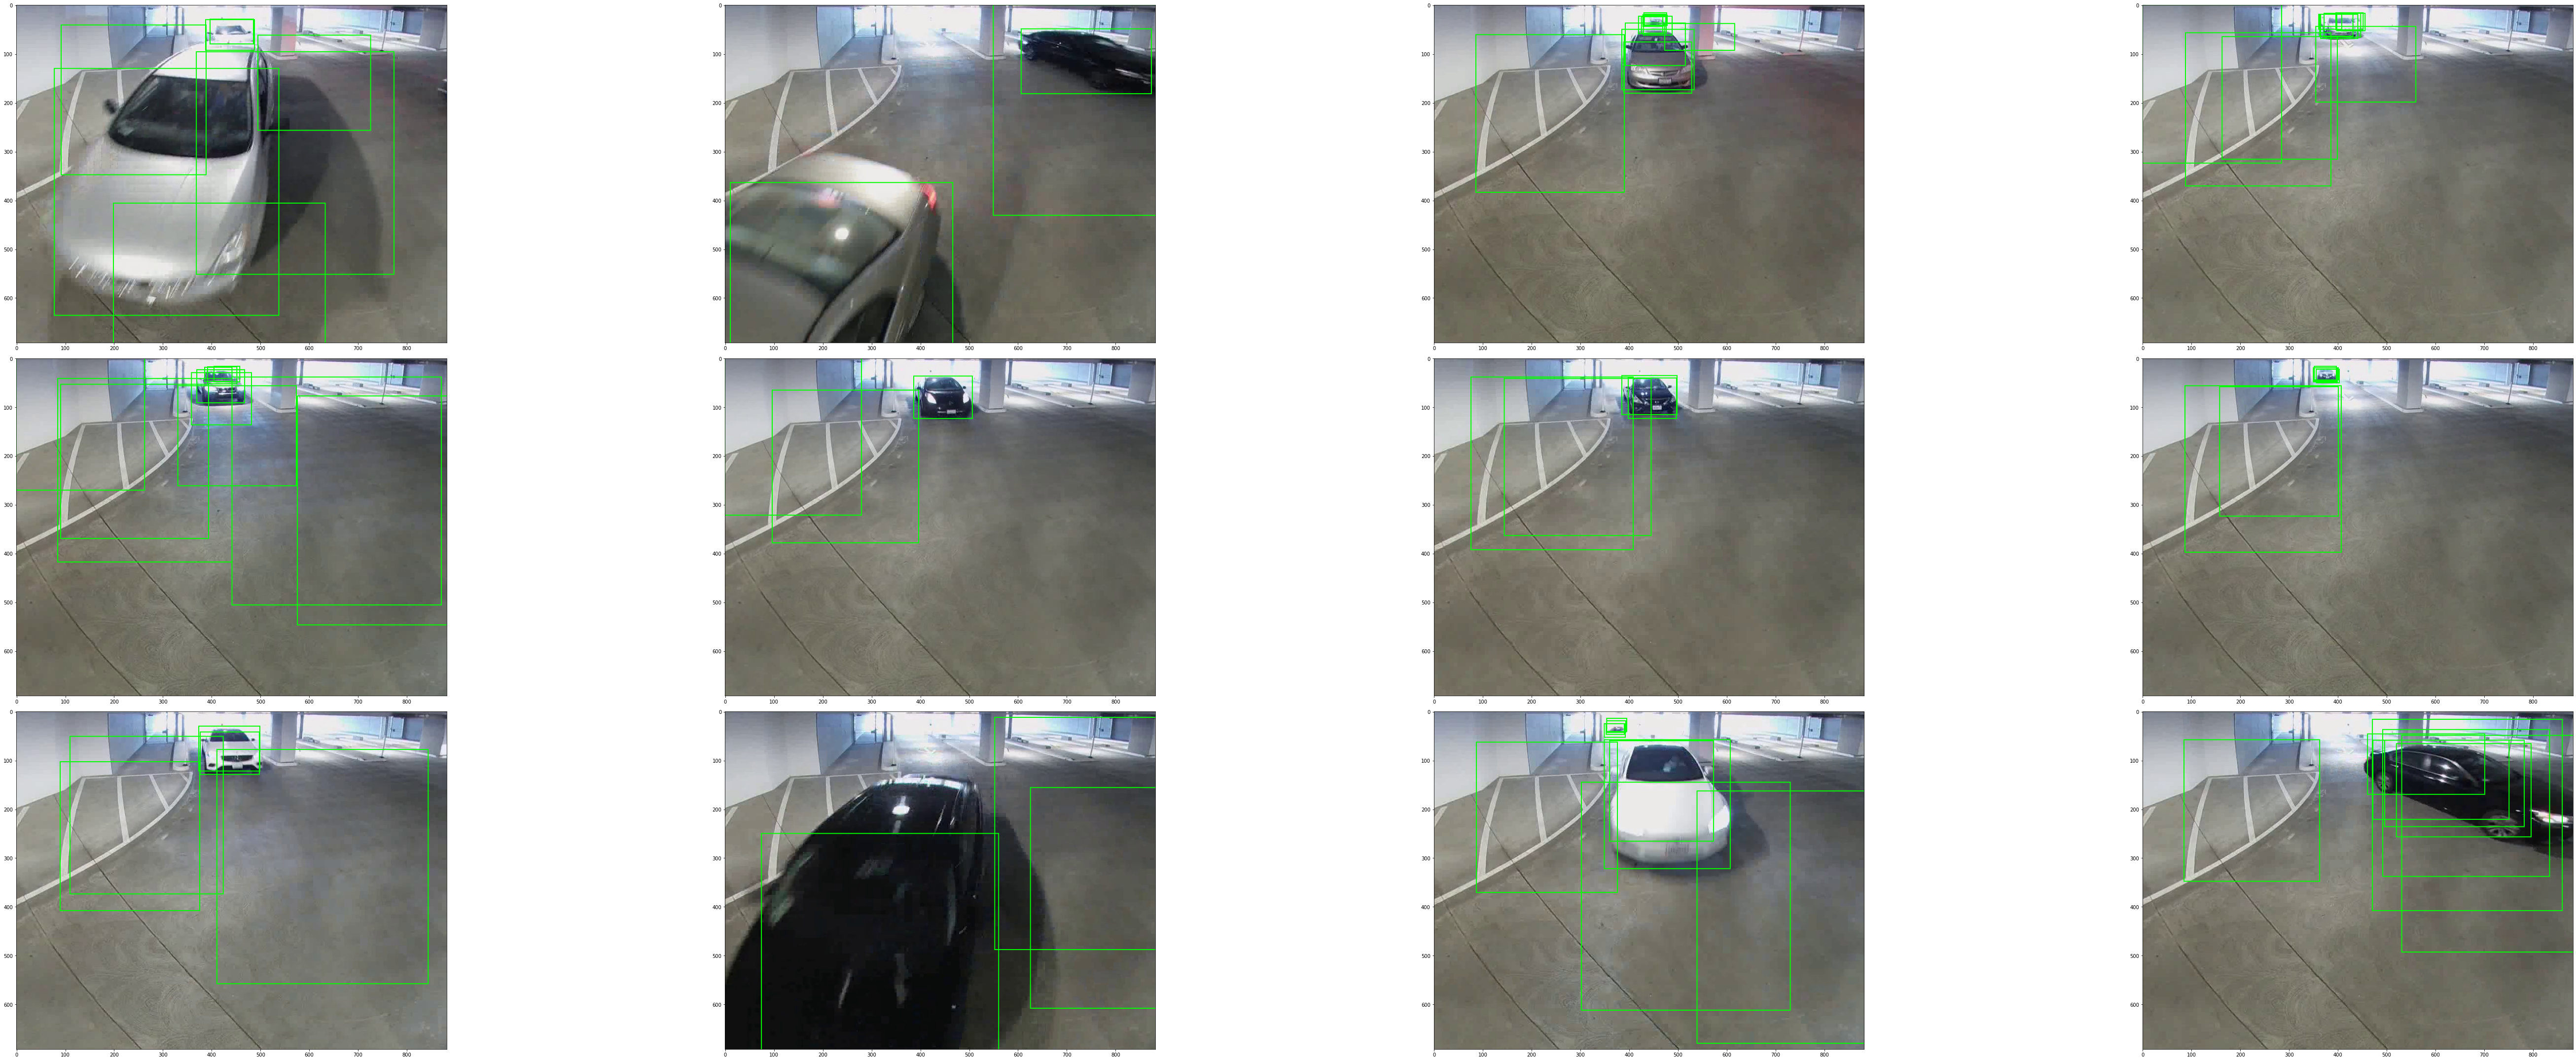

In [21]:
# DO NOT CHANGE THIS CELL
# Visualizing the random 12 images
OUTPUT_PATH = 'tao_infer_testing/images_annotated' # relative path from $USER_EXPERIMENT_DIR.
COLS = 4 # number of columns in the visualizer grid.
IMAGES = 12 # number of images to visualize.

visualize_images(OUTPUT_PATH, num_cols=COLS, num_images=IMAGES)

<a name='s4'></a>
## Model Export ##
The `.tlt` model can be used with the TAO Toolkit for inference but DeepStream does not support using it directly. Instead, the TAO Toolkit uses the `export` subtask to export and prepare a trained model for deploying to DeepStream. 

There are two options to deploy a model trained by the TAO Toolkit to DeepStream: 
1. Generate a `.etlt` model, or encrypted TAO file, using `export` and integrate it in the DeepStream application as we have done before. DeepStream will generate a TensorRT engine file and then run the inference. 
2. Generate a device specific optimized TensorRT engine, which will be a `.trt` or `.engine` file, and integrate it in DeepStream.  

<p><img src='images/important.png' width=720></p>

_TensorRT engines use machine-specific optimizations that are unique to each hardware configuration so it should be generated for each inference environment. Typically the model training environment will have more computational resources than the deployment environment. The TensorRT engine file generated using the TAO Toolkit cannot be used for deployment unless the deployment hardware is identical to the training GPU. On the other hand, the `.etlt` file can be used universally across training and deployment hardware._

When using the `export` subtask, the `-m` argument indicates the path to the `.tlt` model file to be exported, the `-o` argument indicates the path to save the exported `.etlt` model to, the `-k` argument indicates an **encryption key**, and the `-e` argument indicates the experiment spec file. In addition, the TAO Toolkit supports serializing a template config file for the `Gst-nvinfer` element of DeepStream to consume this model. This config file contains the network specific pre-processing parameters and network graph parameters for parsing the etlt model file - very helpful for reference. It also generates a label file, `labels.txt`, that contains the names of the classes that the model was trained for in the order in which the outputs are generated. To generate the DeepStream template files, simply run the `export` subtask using the `--gen_ds_config` option. <br> Execute the below cells to export the trained model. 

In [22]:
# DO NOT CHANGE THIS CELL
# View export usage
!detectnet_v2 export --help

Using TensorFlow backend.
usage: detectnet_v2 export [-h] [--num_processes NUM_PROCESSES] [--gpus GPUS]
                           [--gpu_index GPU_INDEX [GPU_INDEX ...]] [--use_amp]
                           [--log_file LOG_FILE] -m MODEL -k KEY
                           [-o OUTPUT_FILE] [--force_ptq]
                           [--cal_data_file CAL_DATA_FILE]
                           [--cal_image_dir CAL_IMAGE_DIR]
                           [--data_type {fp32,fp16,int8}] [-s]
                           [--gen_ds_config] [--cal_cache_file CAL_CACHE_FILE]
                           [--batches BATCHES]
                           [--max_workspace_size MAX_WORKSPACE_SIZE]
                           [--max_batch_size MAX_BATCH_SIZE]
                           [--batch_size BATCH_SIZE]
                           [--min_batch_size MIN_BATCH_SIZE]
                           [--opt_batch_size OPT_BATCH_SIZE]
                           [-e EXPERIMENT_SPEC] [--engine_file ENGINE_FILE]
      

In [23]:
# DO NOT CHANGE THIS CELL
# Removing a pre-existing copy if there has been any.
!rm -rf $MODELS_DIR/resnet18_detector_unpruned
!mkdir -p $MODELS_DIR/resnet18_detector_unpruned

In [24]:
# DO NOT CHANGE THIS CELL
# Exporting .tlt model
!detectnet_v2 export -m $MODELS_DIR/resnet18_detector/weights/resnet18_detector.tlt \
                     -o $MODELS_DIR/resnet18_detector_unpruned/resnet18_detector.etlt \
                     -k tlt_encode \
                     -e $SPEC_FILES_DIR/combined_training_config.txt \
                     --gen_ds_config

Using TensorFlow backend.
Using TensorFlow backend.
2022-12-23 02:33:17,886 [INFO] iva.detectnet_v2.spec_handler.spec_loader: Merging specification from /dli/task/spec_files/combined_training_config.txt
2022-12-23 02:33:19,949 [INFO] iva.common.export.keras_exporter: Using input nodes: ['input_1']
2022-12-23 02:33:19,949 [INFO] iva.common.export.keras_exporter: Using output nodes: ['output_cov/Sigmoid', 'output_bbox/BiasAdd']
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
NOTE: UFF has been tested with TensorFlow 1.14.0.
DEBUG [/usr/local/lib/python3.6/dist-packages/uff/converters/tensorflow/converter.py:96] Marking ['output_cov/Sigmoid', 'output_bbox/BiasAdd'] as outputs


<a name='s5'></a>
## Deploying to DeepStream ##
The trained model is ready to be deployed in a DeepStream pipeline. We've been provided with a script that will initiate a DeepStream pipeline based on 3 arguments: <br>
`python sample_apps/app_03.py <input video file name> <path to nvinfer configuration file> <output video file name>` <br>
It has the below architecture, much like the one we created in the first part of this course. 

<p><img src='images/deepstream_pipeline.png' width=1080></p>

Execute the below cells to pass the input video through this simple DeepStream pipeline twice, once with the purpose-built TrafficCamNet model as is and another with the custom model. Afterwards, compare the results. <br>
**Note**: Feel free to modify some of the training parameters at the end of the course to improve the model if time allows. 

In [25]:
# DO NOT CHANGE THIS CELL
# Read the nvinfer config file using the TrafficCamNet as is
!cat $SPEC_FILES_DIR/pgie_config_trafficcamnet.txt

[property]
gpu-id=0
net-scale-factor=0.0039215697906911373
tlt-model-key=tlt_encode
tlt-encoded-model=/dli/task/tao_project/models/trafficcamnet_vpruned_v1.0/resnet18_trafficcamnet_pruned.etlt
labelfile-path=/dli/task/tao_project/models/trafficcamnet_vpruned_v1.0/labels.txt
int8-calib-file=/dli/task/tao_project/models/trafficcamnet_vpruned_v1.0/trafficnet_int8.txt
input-dims=3;696;888;0
uff-input-blob-name=input_1
batch-size=1
process-mode=1
model-color-format=0
# 0=FP32, 1=INT8, 2=FP16 mode
network-mode=1
num-detected-classes=4
interval=0
gie-unique-id=1
output-blob-names=output_bbox/BiasAdd;output_cov/Sigmoid
cluster-mode=0

In [26]:
# DO NOT CHANGE THIS CELL
# Run the DeepStream Pipeline with the Purpose-built Model as is
%run sample_apps/app_03.py data/sample_30.h264 spec_files/pgie_config_trafficcamnet.txt output.mp4

# Convert the video to a format that is compatible with Jupyter Lab
!ffmpeg -i output.mp4 output_conv.mp4 -y -loglevel quiet

Creating Pipeline
Adding elements to Pipeline
Linking elements in the Pipeline
Starting pipeline
FPS: 0.06 @ Frame 0.
FPS: 29.34 @ Frame 100.
FPS: 30.04 @ Frame 200.
FPS: 29.95 @ Frame 300.
FPS: 30.08 @ Frame 400.
FPS: 29.98 @ Frame 500.
FPS: 29.99 @ Frame 600.
FPS: 29.98 @ Frame 700.
End-of-stream--- 24.383976459503174 seconds ---


<Figure size 432x288 with 0 Axes>

In [27]:
# DO NOT CHANGE THIS CELL
# Read the nvinfer config file using the custom model
!cat $SPEC_FILES_DIR/pgie_config_resnet18_detector_unpruned.txt

[property]
gpu-id=0
net-scale-factor=0.0039215697906911373
tlt-model-key=tlt_encode
tlt-encoded-model=/dli/task/tao_project/models/resnet18_detector_unpruned/resnet18_detector.etlt
labelfile-path=/dli/task/tao_project/models/resnet18_detector_unpruned/labels.txt
input-dims=3;696;888;0
uff-input-blob-name=input_1
batch-size=1
process-mode=1
model-color-format=0
# 0=FP32, 1=INT8, 2=FP16 mode
network-mode=0
num-detected-classes=1
interval=0
gie-unique-id=1
output-blob-names=output_bbox/BiasAdd;output_cov/Sigmoid
cluster-mode=0

In [28]:
# DO NOT CHANGE THIS CELL
# Run the DeepStream Pipeline with the Custom Model
%run sample_apps/app_03.py /dli/task/data/sample_30.h264 spec_files/pgie_config_resnet18_detector_unpruned.txt output_resnet18_detector_unpruned.mp4

# Convert the video to a format that is compatible with Jupyter Lab
!ffmpeg -i output_resnet18_detector_unpruned.mp4 output_resnet18_detector_unpruned_conv.mp4 -y -loglevel quiet

Creating Pipeline
Adding elements to Pipeline
Linking elements in the Pipeline
Starting pipeline
FPS: 0.12 @ Frame 0.
FPS: 29.98 @ Frame 100.
FPS: 29.98 @ Frame 200.
FPS: 29.4 @ Frame 300.
FPS: 29.99 @ Frame 400.
FPS: 29.46 @ Frame 500.
FPS: 29.99 @ Frame 600.
FPS: 30.01 @ Frame 700.
End-of-stream--- 24.39233374595642 seconds ---


In [29]:
# DO NOT CHANGE THIS CELL
# Compare results
from IPython.display import HTML

HTML("""
<div>
    <video alt="input" width='49%' autoplay>
        <source src="output_conv.mp4" type="video/mp4">
    </video>
    <video alt="output" width='49%' autoplay>
        <source src="output_resnet18_detector_unpruned_conv.mp4" type="video/mp4">
    </video>
</div>
""")

**Well Done**! When you're ready, let's move to the [next notebook](./04_optimizing_a_video_AI_application.ipynb). 

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>